In [1]:
from data_loader import load_latest_iteration, load_all_files

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import render_particles
import os
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from load_combined import load_combined

source_folders = [
      "../data/20251006_155051",
    # "../data/lambda_scaling1/",
    # "../data/growth_comparison_variable_dt_wrong_stress/",
    # "../data/lambda_scaling1_wrong_stress/",
]

# find recursive subfolders within source_folders
sim_dirs = []
for folder in source_folders:
    for root, dirs, files in os.walk(folder):
        # skip if /data as last part of path
        if "logs" in root or "data" in root.split(os.sep)[-1]:
            continue

        if any(f.endswith(".pvtu") for f in os.listdir(root)):
            sim_dirs.append(os.path.join(root))

particles_dict, sim_dict, params_dict = load_combined(sim_dirs, offset=-0)

loading ../data/20251006_155051/1759590515417.367/output_hard/112ranks/vtk_output_hard
loading ../data/20251006_155051/1759590515417.367/output_soft/112ranks/vtk_output_soft


In [3]:
particles_dict

,gid,quaternion_x,quaternion_y,quaternion_z,quaternion_w,orientation_x,orientation_y,orientation_z,orientation_angle,length,...,velocity_angular_y,velocity_angular_z,rank,x,y,z,Mode,Sensitivity,sim_dir,offset
0,133801,-0.184406,0.0,0.0,0.982850,-0.931989,-0.362486,0.0,0.370934,1.16287,...,0.0,-0.012545,105,154.357,14.83140,0.0,hard,../data/20251006_155051/1759590515417.367/outp...,20251006_155051,0
1,133802,-0.853471,0.0,0.0,-0.521141,0.456824,0.889557,0.0,1.096370,1.96705,...,0.0,-0.068100,105,154.354,-67.00300,0.0,hard,../data/20251006_155051/1759590515417.367/outp...,20251006_155051,0
2,133803,0.934382,0.0,0.0,-0.356272,0.746141,-0.665788,-0.0,2.413040,1.53630,...,0.0,-0.032381,105,154.357,44.43550,0.0,hard,../data/20251006_155051/1759590515417.367/outp...,20251006_155051,0
3,133804,-0.945916,0.0,0.0,-0.324411,0.789515,0.613732,0.0,0.660778,1.33365,...,0.0,0.034273,105,154.371,6.37547,0.0,hard,../data/20251006_155051/1759590515417.367/outp...,20251006_155051,0
4,133805,0.101459,0.0,0.0,0.994840,-0.979412,0.201872,0.0,2.938320,1.10789,...,0.0,0.040331,105,154.395,35.44670,0.0,hard,../data/20251006_155051/1759590515417.367/outp...,20251006_155051,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1170070,1033016,0.986937,0.0,0.0,-0.161106,0.948090,-0.318002,-0.0,2.817970,1.51163,...,0.0,-159.175000,110,207.026,-5.32577,0.0,soft,../data/20251006_155051/1759590515417.367/outp...,20251006_155051,0
1170071,1033017,0.176041,0.0,0.0,-0.984383,-0.938019,-0.346583,-0.0,0.353925,1.57995,...,0.0,-3.356360,110,207.034,-23.37820,0.0,soft,../data/20251006_155051/1759590515417.367/outp...,20251006_155051,0
1170072,1033018,-0.404527,0.0,0.0,-0.914526,-0.672716,0.739901,0.0,2.308670,1.46670,...,0.0,-0.335940,110,207.038,-28.81540,0.0,soft,../data/20251006_155051/1759590515417.367/outp...,20251006_155051,0
1170073,1033019,0.109674,0.0,0.0,-0.993968,-0.975943,-0.218025,-0.0,0.219790,1.31454,...,0.0,-217.346000,110,207.063,-17.25080,0.0,soft,../data/20251006_155051/1759590515417.367/outp...,20251006_155051,0


In [4]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import cKDTree
import numpy as np


def build_cell_graph(cells, distance_threshold=1.0, orientation_threshold=0.03):
    """
    Build a graph of cells where edges represent contact + orientation similarity.

    Parameters
    ----------
    cells : pd.DataFrame
        Columns: ['x', 'y', 'orientation_angle'] (0..pi)
    distance_threshold : float
        Max distance for edge
    orientation_threshold : float
        Max relative orientation difference (fraction of pi)

    Returns
    -------
    G : networkx.Graph
        Graph with nodes as cells and edges as contacts
    """
    positions = cells[['x', 'y']].values
    angles = cells['orientation_angle'].values

    tree = cKDTree(positions)
    neighbors = tree.query_pairs(r=distance_threshold)

    G = nx.Graph()
    G.add_nodes_from(range(len(cells)))

    for i, j in neighbors:
        angle_diff = abs(angles[i] - angles[j])
        angle_diff = min(angle_diff, np.pi - angle_diff)
        if angle_diff < orientation_threshold * np.pi:
            G.add_edge(i, j)

    return G, positions


def render_graph_hsv(G, positions, data, filename, clusters=None):
    pos_dict = {i: (x, y) for i, (x, y) in enumerate(positions)}
    plt.figure(figsize=(10, 10))

    if clusters is None:
        nx.draw(G, pos=pos_dict, node_size=10, node_color='skyblue',
                edge_color='gray', with_labels=False)
    else:
        # Compute average angle for each cluster
        cluster_angles = []
        cluster_color_dict = {}
        for cluster in clusters:
            angles = data.iloc[list(cluster)]['orientation_angle'].values
            mean_angle = np.mean(angles)
            cluster_angles.append(mean_angle)

        # Map mean angles to HSV hue (0..1)
        cluster_hues = np.array(cluster_angles) / np.pi  # 0..1 range

        # Assign color per node based on cluster hue
        node_colors = np.zeros((len(data), 3))
        for idx, cluster in enumerate(clusters):
            hue = cluster_hues[idx]

            rgb = mcolors.hsv_to_rgb([hue, 1.0, 1.0])  # Full saturation, value
            for node in cluster:
                cluster_color_dict[node] = rgb
                node_colors[node] = rgb

        nx.draw(G, pos=pos_dict, node_size=10, node_color=node_colors,
                edge_color='gray', with_labels=False)

        #  create new dictionary with cluster colors

    plt.gca().set_aspect('equal')
    plt.savefig(filename, dpi=300)

    if clusters is not None:
        return cluster_color_dict

In [5]:
from scipy.ndimage import gaussian_filter1d
import pandas as pd
import seaborn as sns

MODE_COLORS = {"hard": "blue", "soft": "orange", "Weady et al.": "black"}
LINE_STYLES = {"$\\lambda = 10^{-2}$": "solid",
               "$\\lambda = 10^{-3}$": "dashed", "$\\lambda = 10^{-4}$": "dotted"}


In [6]:
def makeplot(data, x, y, xlabel=None, ylabel=None, outname=None, variable="density",
             xscale=None, yscale=None,
             **kwargs):

    fig, ax = plt.subplots(figsize=(10, 6))
    outname = outname or f"{y}_vs_{x}.png"

    sns.lineplot(data, x=x,                 y=y,
                 hue="Mode", marker="o", ax=ax, **kwargs, lw=2, ms=10)

    if xscale:
        ax.set_xscale(xscale, base=2)
    if yscale:
        ax.set_yscale(yscale, base=2)

    ax.set_xlabel(xlabel or x, fontsize=20)
    ax.set_ylabel(ylabel or y, fontsize=20)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid(True)
    ax.legend(fontsize=22)

    if outname:
        fig.savefig(outname, dpi=300, bbox_inches="tight")

In [ ]:
from render_particles import draw_particles_cluster


def plot_orientation_distribution(particles, filename):

    fig, ax = plt.subplots(figsize=(10, 6))
    particles["orientation_angle"].plot.hist(bins=25,
                                             color='gray', edgecolor='black', density=True)

    # put 0 pi/2 and pi as x axis ticks
    ax.set_xticks([0, np.pi/2, np.pi], ['0', 'π/2', 'π'])

    ax.set_xlabel("Orientation Angle (radians)", fontsize=20)
    ax.set_ylabel("Frequency", fontsize=20)

    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

    ax.legend(fontsize=16)

    fig.savefig(filename, dpi=300)


def spherocylinder_area(length,  radius=0.25):
    """
    Calculate projected area of a spherocylinder
    Area = rectangle + 2 semicircles = 2*r*L + π*r²
    """
    return 2 * radius * (length-2*radius) + np.pi * radius**2


def Pa(A, A_star):
    return 0.1*np.exp(-A / A_star)


def plot_cluster_area_kde(particles, clusters, filename):
    fig, ax = plt.subplots(figsize=(10, 6))

    cluster_areas = []
    for cluster in clusters:
        cluster_lengths = particles.iloc[cluster]['length']
        cluster_areas.append(sum(spherocylinder_area(l)
                             for l in cluster_lengths))

    cluster_series = pd.Series(cluster_areas)

    x = np.linspace(cluster_series.min(), cluster_series.max(), 100)

    cluster_series.plot.kde()
    plt.plot(x, Pa(x, 20.0), label='A* = 20.0', color='red', linewidth=2)

    ax.set_xlim(cluster_series.min(), cluster_series.max())
    ax.set_ylim(1e-6, None)

    # log scale x axis
    ax.set_yscale('log')

    ax.set_xlabel("Cluster Area", fontsize=20)
    ax.set_ylabel("Probability Density", fontsize=20)

    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

    ax.grid(True)
    ax.legend(fontsize=16)

    fig.savefig(filename, dpi=300)


def plot_cluster_area_distribution(particles, clusters, filename):
    fig, ax = plt.subplots(figsize=(10, 6))

    # determine average length per cluster
    cluster_areas = []
    for cluster in clusters:
        cluster_lengths = particles.iloc[cluster]['length']
        cluster_areas.append(sum(spherocylinder_area(l)
                             for l in cluster_lengths))

    # plot probability distribution of cluster areas
    ax.hist(cluster_areas, bins=30, color='gray',
            edgecolor='black', density=True)

    ax.set_yscale('log')

    ax.set_xlabel("Cluster Area", fontsize=20)
    ax.set_ylabel("Probability Density", fontsize=20)

    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

    ax.legend(fontsize=16)

    fig.savefig(filename, dpi=300)

In [8]:
particles_dict['area'] = particles_dict['length'].apply(spherocylinder_area)

Processing ('hard', '../data/20251006_155051/1759590515417.367/output_hard/112ranks/vtk_output_hardassumed $\\lambda = 10^{-2}$', '20251006_155051', np.int64(0))


FileNotFoundError: [Errno 2] No such file or directory: 'graph_hard_../data/20251006_155051/1759590515417.367/output_hard/112ranks/vtk_output_hardassumed $\\lambda = 10^{-2}$.png'

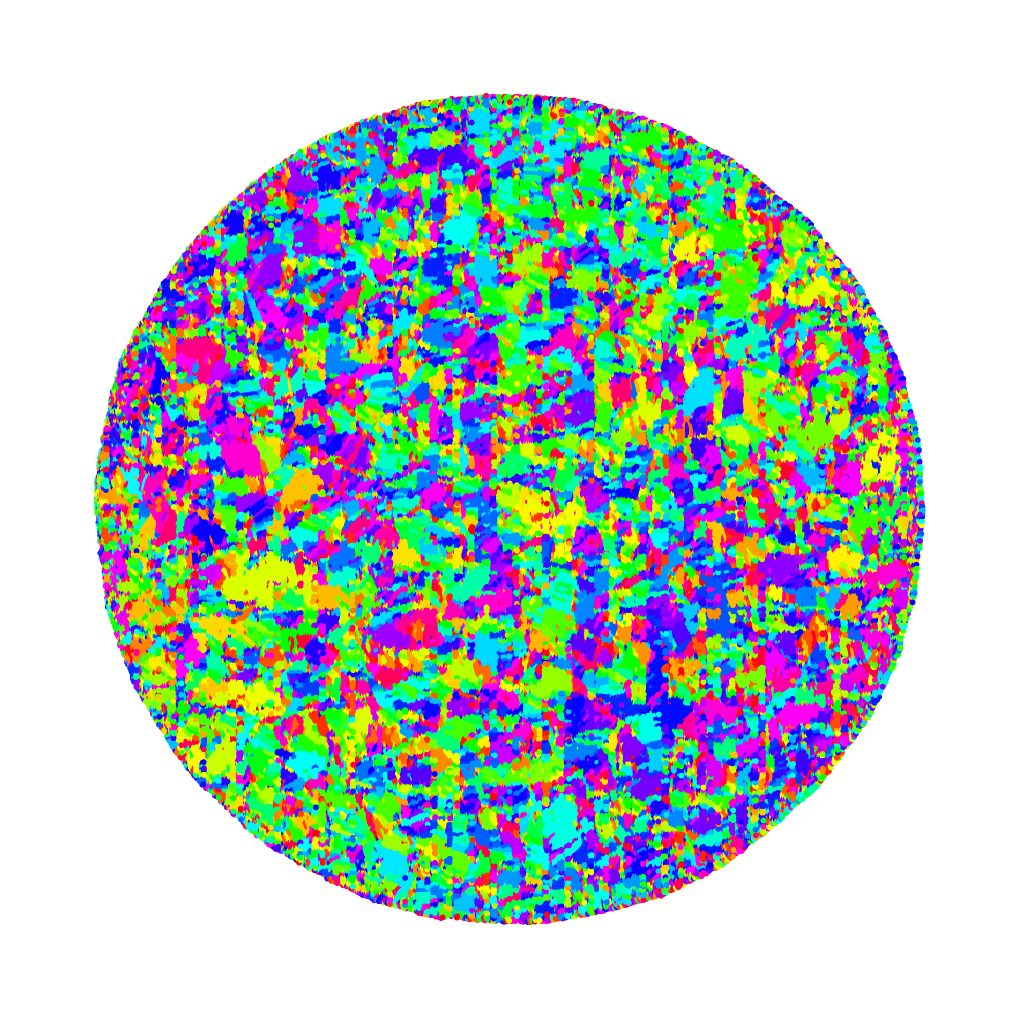

In [11]:
updated_particles_dict = []

for key, particles in particles_dict.groupby(["Mode", "Sensitivity", "sim_dir", "offset"]):
    print(f"Processing {key}")

    G, positions = build_cell_graph(
        particles, distance_threshold=2.2, orientation_threshold=0.03)

    clusters = [list(c) for c in nx.connected_components(G)]
    # add cluster field to each particle

    for cluster_id, cluster in enumerate(clusters):
        particles.loc[particles.index[cluster], 'cluster'] = cluster_id

    updated_particles_dict.append(particles)

    # save graph
    render_graph_hsv(G, positions, particles,
                     filename=f"graph_{key[0]}_{key[1]}.png",
                     clusters=clusters)

particles_dict = pd.concat(updated_particles_dict, ignore_index=True)

('hard', '20251006_155051', np.int64(0))
('soft', '20251006_155051', np.int64(0))


/tmp/ipykernel_1196369/1702201120.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Mode, Sensitivity, Sim_dir, Offset",
/tmp/ipykernel_1196369/1702201120.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="Mode, Sensitivity, Sim_dir, Offset",


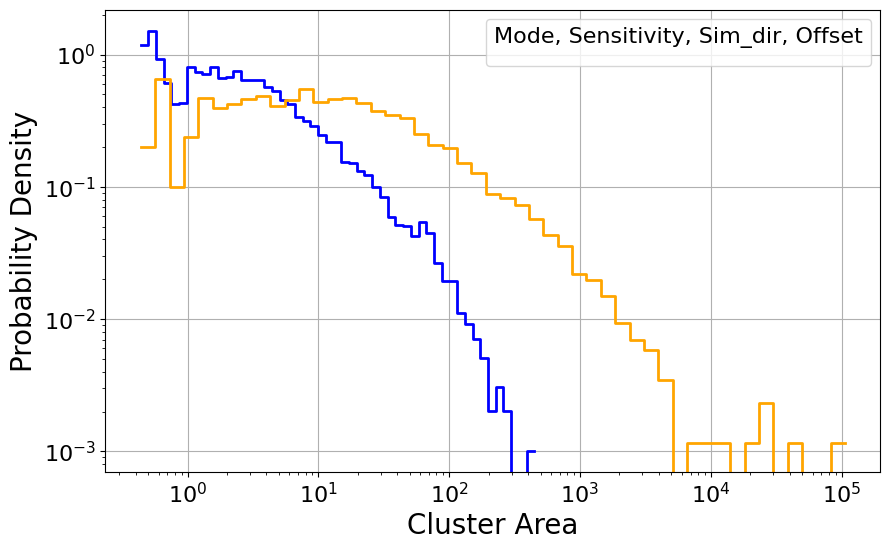

In [ ]:

fig, ax = plt.subplots(figsize=(10, 6))

for key, particles in particles_dict.groupby(["Mode",  "sim_dir", "offset"]):
    print(key)

    # calculate total cluster area per cluster
    cluster_summary = (
        particles.groupby('cluster')
        .agg(
            total_area=('area', 'sum'),
            center_x=('x', 'mean'),
            center_y=('y', 'mean'),
            center_z=('z', 'mean'),
            count=('gid', 'count'),
            mode=('Mode', 'first'),
            sensitivity=('Sensitivity', 'first'),
        )
        .reset_index())
    cluster_summary['radius'] = np.sqrt(
        cluster_summary['center_x']**2 + cluster_summary['center_y']**2)

    sns.histplot(data=cluster_summary, x='total_area', stat="density",  
                fill=False,   ax=ax, lw=2,  hue="mode",  palette=MODE_COLORS, log_scale=True, element="step")

# set xllim
ax.set_yscale('log')
# ax.set_xlim(1, 7300)
# ax.set_ylim(1e-7, 1)
ax.set_xlabel("Cluster Area", fontsize=20)
ax.set_ylabel("Probability Density", fontsize=20)

ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid(True)
ax.legend(title="Mode, Sensitivity, Sim_dir, Offset",
          fontsize=14, title_fontsize=16)
ax.legend(title="Mode, Sensitivity, Sim_dir, Offset",
          fontsize=14, title_fontsize=16)